Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import datetime

[*********************100%%**********************]  4 of 4 completed

Fetching historical data...
Worst-of Payouts:
         Date                      Action     Amount
0  2022-10-25                 Coupon Paid   250000.0
1  2023-01-25                   No Coupon   250000.0
2  2023-04-25                   No Coupon   250000.0
3  2023-07-25  Maturity: Nominal Returned  5250000.0

Average-of Payouts:
         Date                      Action     Amount
0  2022-10-25                 Coupon Paid   250000.0
1  2023-01-25                   No Coupon   250000.0
2  2023-04-25                 Coupon Paid   500000.0
3  2023-07-25  Maturity: Nominal Returned  5500000.0


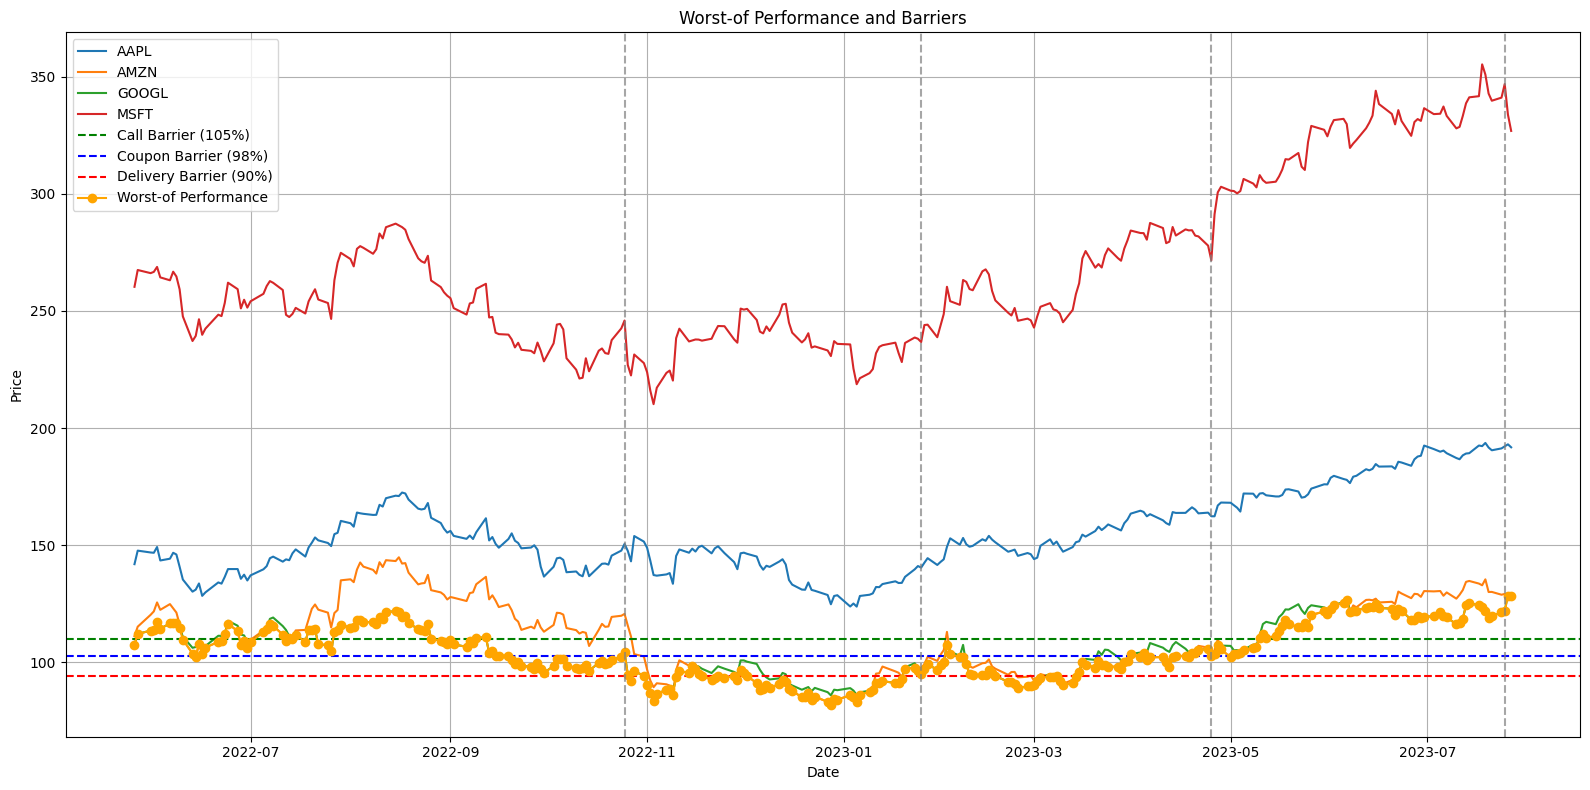

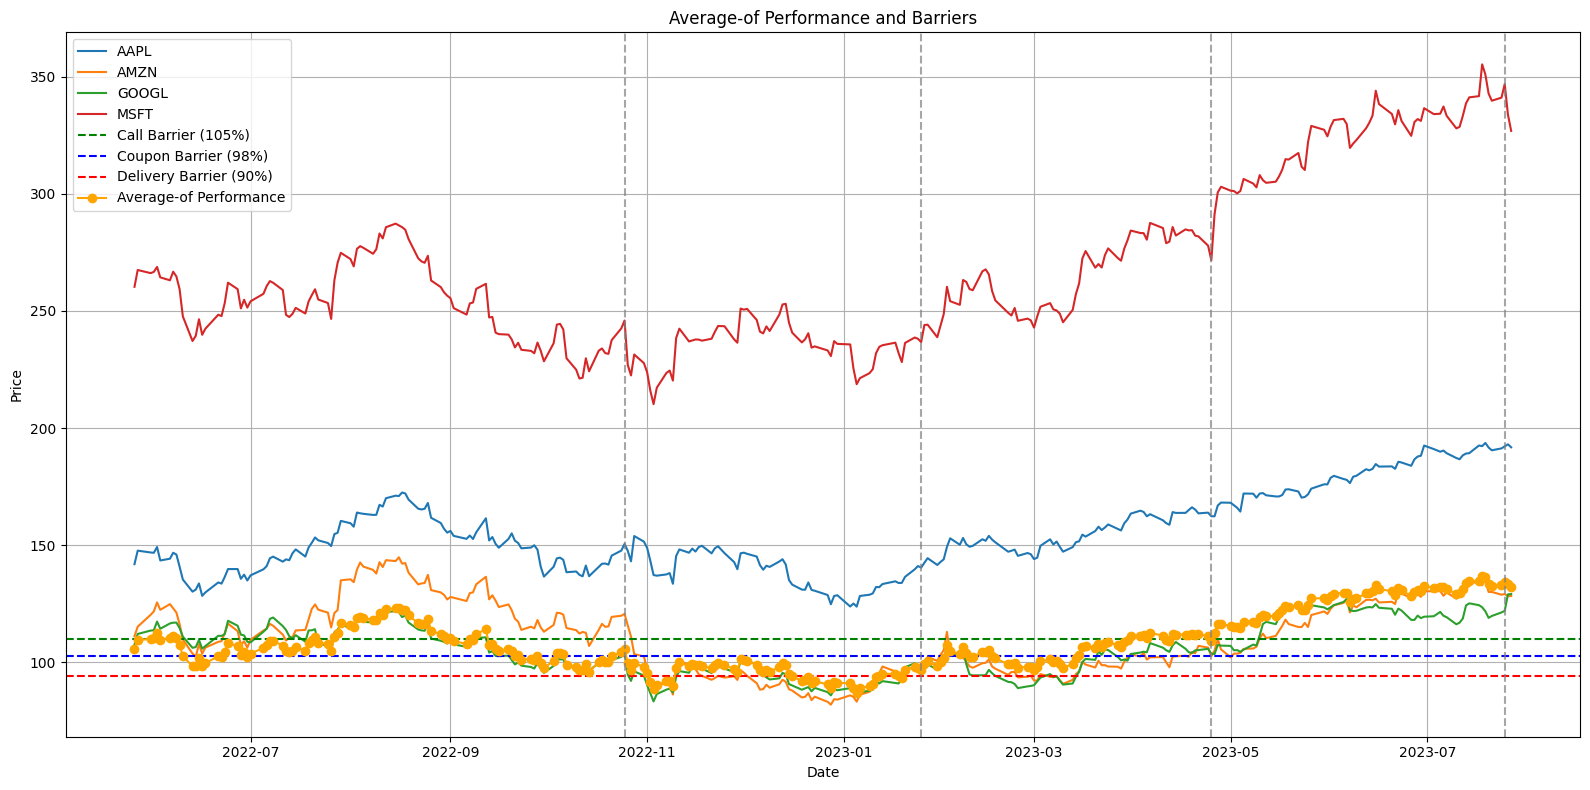

In [8]:
class AutocallableOption:
    def __init__(self, investment, annual_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates):
        self.investment = investment
        self.annual_coupon_rate = annual_coupon_rate
        self.quarterly_coupon_rate = annual_coupon_rate / 4
        self.call_barrier = call_barrier
        self.coupon_barrier = coupon_barrier
        self.delivery_barrier = delivery_barrier
        self.observation_dates = observation_dates

    def fetch_data(self, tickers, start_date, end_date):
        print("Fetching historical data...")
        data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
        return data

    def calculate_performance(self, prices, initial_prices, method="worst-of"):
        if method == "worst-of":
            return prices.min(axis=1) / initial_prices.min()
        elif method == "average-of":
            return prices.mean(axis=1) / initial_prices.mean()
        else:
            raise ValueError("Invalid method. Use 'worst-of' or 'average-of'.")

    def calculate_payout(self, performance, method="worst-of"):
        coupons = []
        total_payout = 0
        actions = []
        redeemed = False

        for i, date in enumerate(self.observation_dates[:-1]):
            perf = performance.loc[date]
            if perf >= self.call_barrier:
                total_payout = self.investment + self.investment * self.quarterly_coupon_rate * (i + 1)
                actions.append((date, "Early Redemption", total_payout))
                redeemed = True
                break
            elif perf >= self.coupon_barrier:
                coupons.append(self.quarterly_coupon_rate * self.investment)
                actions.append((date, "Coupon Paid", sum(coupons)))
            else:
                actions.append((date, "No Coupon", sum(coupons)))

        if not redeemed:
            final_perf = performance.loc[self.observation_dates[-1]]
            if final_perf >= self.delivery_barrier:
                total_payout = self.investment + sum(coupons)
                actions.append((self.observation_dates[-1], "Maturity: Nominal Returned", total_payout))
            else:
                total_payout = self.investment * final_perf
                actions.append((self.observation_dates[-1], "Maturity: Delivery Value", total_payout))

        return pd.DataFrame(actions, columns=["Date", "Action", "Amount"])

    def plot_results(self, prices, initial_prices, performance, method="worst-of"):
        plt.figure(figsize=(16, 8))

        # Plot individual asset prices
        for ticker in prices.columns:
            plt.plot(prices.index, prices[ticker], label=ticker)

        # Add barriers
        plt.axhline(initial_prices.min() * self.call_barrier, color='green', linestyle='--', label='Call Barrier (105%)')
        plt.axhline(initial_prices.min() * self.coupon_barrier, color='blue', linestyle='--', label='Coupon Barrier (98%)')
        plt.axhline(initial_prices.min() * self.delivery_barrier, color='red', linestyle='--', label='Delivery Barrier (90%)')

        # Plot performance
        plt.plot(performance.index, performance * initial_prices.min(), color='orange', linestyle='-', marker='o', label=f"{method.capitalize()} Performance")

        # Observation dates (converted to datetime)
        for date in map(pd.to_datetime, self.observation_dates):
            plt.axvline(date, color='gray', linestyle='--', alpha=0.7)

        plt.title(f"{method.capitalize()} Performance and Barriers")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()


# Main parameters
investment = 5_000_000
annual_coupon_rate = 0.20
call_barrier = 1.05
coupon_barrier = 0.98
delivery_barrier = 0.90
observation_dates = ['2022-10-25', '2023-01-25', '2023-04-25', '2023-07-25']
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Create an instance of the option
option = AutocallableOption(investment, annual_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates)

# Fetch data
start_date = "2022-05-26"
end_date = "2023-07-28"
prices = option.fetch_data(tickers, start_date, end_date)

# Calculate initial prices
initial_prices = prices.loc['2022-07-26']

# Calculate performance
worst_performance = option.calculate_performance(prices, initial_prices, method="worst-of")
average_performance = option.calculate_performance(prices, initial_prices, method="average-of")

# Calculate payouts
worst_payouts = option.calculate_payout(worst_performance, method="worst-of")
average_payouts = option.calculate_payout(average_performance, method="average-of")

# Display results
print("Worst-of Payouts:")
print(worst_payouts)
print("\nAverage-of Payouts:")
print(average_payouts)

# Plot results
option.plot_results(prices, initial_prices, worst_performance, method="worst-of")
option.plot_results(prices, initial_prices, average_performance, method="average-of")